In [1]:
# imports

import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from matplotlib import pyplot as plt
from pathlib import Path

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#FFB1CA', '#63B9FF', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 100

# utility function for moving histplot legends
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    

# Collect data

In [3]:
# gather cross validation data

data_dir = Path('../../data/4-fitting')
outdir = Path('.')

results_df = pd.DataFrame()
for cyano in ['pro', 'syn']:
    df = pd.read_csv(data_dir / cyano / 'cv_data.csv')
    df['genus'] = cyano
    if len(df) == 0:
        results_df = df
    else:
        results_df = pd.concat([results_df, df])

# add features
results_df['comparison'] = (results_df['modeled_replicate'] == results_df['comparison_replicate']).map({
    True: 'Fitting', False: 'Cross-Validation'
})
results_df = results_df.sort_values(
    ['genus', 'bootstrap_id', 'rank', 'lambda', 'replicate_pair']).reset_index(drop=True)
results_df['Sparsity Coefficient'] = results_df['lambda'].astype(str)

# limit to bootstraps used in grid search
results_df = results_df[results_df['bootstrap_id'].isin(range(10))].reset_index(drop=True)

results_df


,bootstrap_id,rank,lambda,modeled_replicate,comparison_replicate,replicate_pair,n_components,mean_gene_sparsity,relative_sse,fms_cv,genus,comparison,Sparsity Coefficient
0,0,1,0.0,A,A,"A, A",1,5023.00,0.864485,NaN,pro,Fitting,0.0
1,0,1,0.0,A,B,"A, B",1,5023.00,0.925260,0.002083,pro,Cross-Validation,0.0
2,0,1,0.0,A,C,"A, C",1,5023.00,0.937960,0.000951,pro,Cross-Validation,0.0
3,0,1,0.0,B,A,"B, A",1,5023.00,1.120335,NaN,pro,Cross-Validation,0.0
4,0,1,0.0,B,B,"B, B",1,5023.00,0.845432,NaN,pro,Fitting,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28075,9,50,100.0,B,B,"B, B",2,0.04,0.999192,NaN,syn,Fitting,100.0
28076,9,50,100.0,B,C,"B, C",2,0.04,0.999340,0.033400,syn,Cross-Validation,100.0
28077,9,50,100.0,C,A,"C, A",2,0.04,0.999033,NaN,syn,Cross-Validation,100.0
28078,9,50,100.0,C,B,"C, B",2,0.04,0.999132,NaN,syn,Cross-Validation,100.0


# Plot cross-validation data

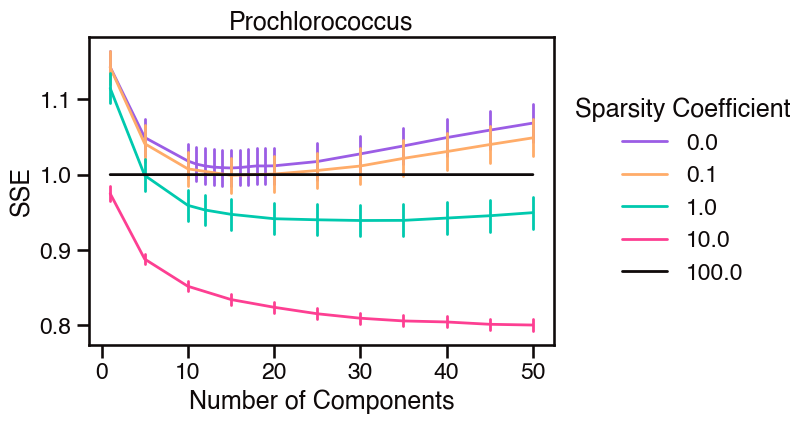

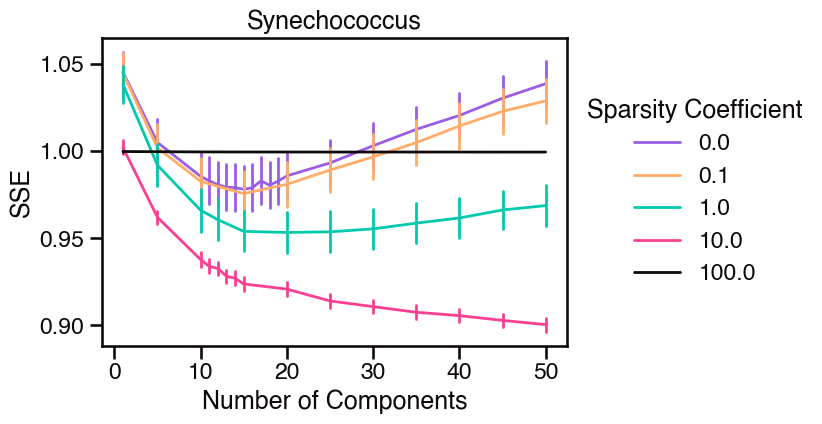

In [4]:
# look at relative_sse vs rank

for cyano in ['pro', 'syn']:
    # define data
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Cross-Validation']
    plot_df = plot_df[plot_df['rank'].isin([1, 5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 45, 50])]
    plot_df = plot_df[plot_df['lambda'].isin([0., 0.1, 1., 10., 100.])]

    # plot figure
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
        hue='Sparsity Coefficient', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        ax=axis, 
    );

    plt.title({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano])
    plt.xlabel('Number of Components');
    plt.ylabel('SSE')
    plt.legend(title='Sparsity Coefficient', loc='center left', bbox_to_anchor=[1, 0.5]);
    # plt.savefig(outdir / '{}-sse-v-rank.png'.format(cyano), bbox_inches='tight')


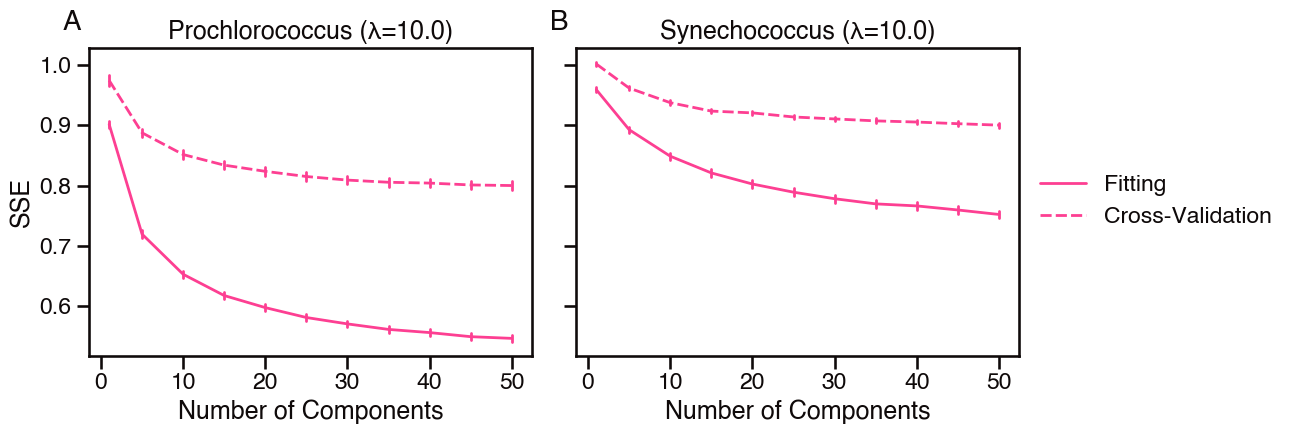

In [5]:
# look at relative_sse vs rank

# define data
lamb = 10.0

# set up subplots
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4), gridspec_kw={'wspace': 0.1})
annotations = {0: 'A', 1: 'B'}
annot_kws = dict(
    xy=(-0.06, 1.08), xycoords='axes fraction', va='center', ha='left', 
    weight='bold', fontsize=20, annotation_clip=False
)

for i, genus in enumerate(['pro', 'syn']):
    # define data
    plot_df = results_df[results_df['genus'] == genus]
    plot_df = plot_df[plot_df['lambda'] == lamb]
    plot_df = plot_df[plot_df['rank'].isin([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 200, 400, 800])]

    # plot figure
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
        color=sns.color_palette()[3], 
        style='comparison', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        ax=axes[i], 
        legend=i
    );

    # labels and such
    axes[i].annotate(annotations[i], **annot_kws)
    axes[i].set(title='{} (λ={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[genus], lamb), 
                xlabel='Number of Components', ylabel='SSE')
    if i:
        axes[i].legend(loc='center left', bbox_to_anchor=[1, 0.5]);
    
    # # save figure
    # fig.savefig(outdir / 'high-rank-sse.png', bbox_inches='tight')
    

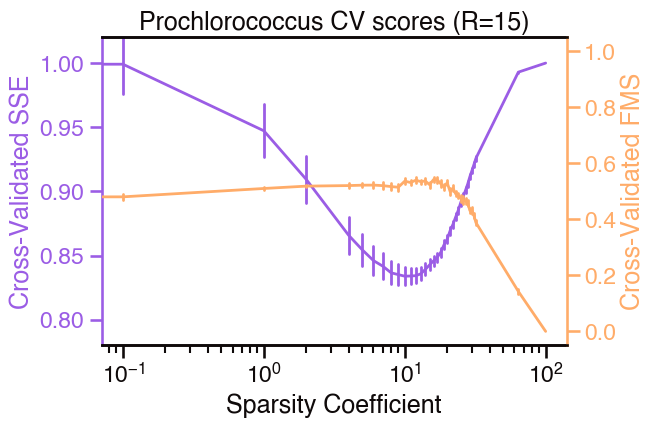

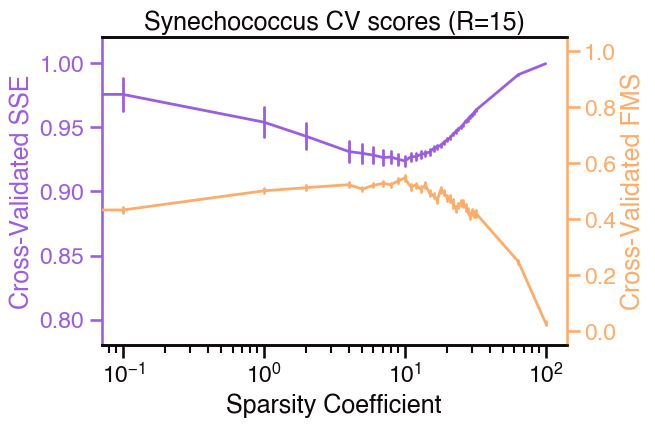

In [6]:
# look at SSE and FMS vs lambda

# define data
ranks = {'pro': 15, 'syn': 15}

for cyano in ['pro', 'syn']:
    rank = ranks[cyano]
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Cross-Validation']
    plot_df = plot_df[plot_df['rank'] == rank]

    # plot SSE
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = False
    color = sns.color_palette()[0]
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='lambda', 
        y='relative_sse', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis, 
        legend=False
    )
    axis.set(ylim=[0.78, 1.02], xlabel='Sparsity Coefficient', ylabel='Cross-Validated SSE')
    axis.yaxis.label.set_color(color)
    axis.tick_params(axis='y', colors=color)
    axis.spines['left'].set_color(color)

    # plot FMS
    color = sns.color_palette()[1]
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = False
    axis2 = plt.twinx(axis)
    sns.lineplot(
        x='lambda', 
        y='fms_cv', 
        color=color, 
    #     style='rank', 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis2, 
        legend=False
    )
    axis2.set(ylim=[-.05, 1.05], xlabel='Sparsity Coefficient', ylabel='Cross-Validated FMS')
    axis2.yaxis.label.set_color(color)
    axis2.tick_params(axis='y', colors=color)
    axis2.spines['right'].set_color(color)

    # put defaults back where you found them
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = True

    # fix x axis stuff
    plt.xscale('log');
    plt.title('{} CV scores (R={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano], rank));
    # plt.savefig(outdir / '{}-cv-scores-v-lambda.png'.format(cyano), bbox_inches='tight')


# calculate optimal sparsity

In [7]:
# find rank of minimum SSE with no sparsity applied

summary_df = results_df[results_df['comparison'] == 'Cross-Validation']
summary_df = summary_df[summary_df['bootstrap_id'].isin(range(10))]
summary_df = summary_df[summary_df['lambda'].isin([0.0])]
summary_df = summary_df.groupby(['genus', 'rank', 'lambda'])[['mean_gene_sparsity', 'relative_sse', 'fms_cv']].agg(
    mean_gene_sparsity=('mean_gene_sparsity', 'mean'), 
    relative_sse=('relative_sse', 'mean'), 
    fms_cv=('fms_cv', 'mean'), 
    fms_sem=('fms_cv', 'sem'), 
    bootstraps=('fms_cv', 'count')
).reset_index()

# print dataframe
summary_df.set_index(['genus', 'rank', 'lambda']).sort_values(
    ['genus', 'relative_sse'], ascending=True
).head(50)


mean_gene_sparsity  relative_sse    fms_cv   fms_sem  \
genus rank lambda                                                         
pro   15   0.0                 5023.0      1.008813  0.288223  0.016175   
      14   0.0                 5023.0      1.009242  0.321719  0.017938   
      16   0.0                 5023.0      1.009382  0.280509  0.014450   
      13   0.0                 5023.0      1.009933  0.314091  0.013771   
      17   0.0                 5023.0      1.010504  0.266124  0.016834   
      19   0.0                 5023.0      1.011492  0.241671  0.018003   
      12   0.0                 5023.0      1.011510  0.313982  0.015649   
      18   0.0                 5023.0      1.011574  0.246325  0.014534   
      20   0.0                 5023.0      1.011702  0.238813  0.014908   
      11   0.0                 5023.0      1.013966  0.306019  0.013963   
      25   0.0                 5023.0      1.017389  0.220268  0.016041   
      10   0.0                 5023.0      1.018185  0.322322  0.014977   
      30   0.0                 5023.0      1.027564  0.232783  0.012415   
      35   0.0                 5023.0      1.038138  0.234593  0.008515   
      40   0.0                 5023.0      1.049213  0.246260  0.007088   
      5    0.0                 5023.0      1.049390  0.418019  0.023182   
      45   0.0                 5023.0      1.059102  0.250511  0.004255   
      50   0.0                 5023.0      1.068510  0.248490  0.004473   
      1    0.0                 5023.0      1.142920  0.034103  0.007302   
syn   15   0.0                 6478.0      0.978135  0.290575  0.011355   
      16   0.0                 6478.0      0.978998  0.291067  0.010225   
      14   0.0                 6478.0      0.979020  0.319317  0.008996   
      13   0.0                 6478.0      0.979364  0.333183  0.009606   
      18   0.0                 6478.0      0.980436  0.257814  0.007134   
      12   0.0                 6478.0      0.980660  0.371333  0.013231   
      19   0.0                 6478.0      0.982798  0.226020  0.007547   
      11   0.0                 6478.0      0.982945  0.352606  0.010164   
      17   0.0                 6478.0      0.982956  0.263334  0.007775   
      10   0.0                 6478.0      0.985547  0.342960  0.012623   
      20   0.0                 6478.0      0.985790  0.220132  0.008580   
      25   0.0                 6478.0      0.993215  0.211081  0.007337   
      30   0.0                 6478.0      1.003078  0.192471  0.006540   
      5    0.0                 6478.0      1.005006  0.353203  0.021068   
      35   0.0                 6478.0      1.012496  0.186363  0.004441   
      40   0.0                 6478.0      1.020471  0.199088  0.005934   
      45   0.0                 6478.0      1.030378  0.184243  0.006046   
      50   0.0                 6478.0      1.038666  0.185586  0.004754   
      1    0.0                 6478.0      1.045374  0.058916  0.031281   

                   bootstraps  
genus rank lambda              
pro   15   0.0             30  
      14   0.0             30  
      16   0.0             30  
      13   0.0             30  
      17   0.0             30  
      19   0.0             30  
      12   0.0             30  
      18   0.0             30  
      20   0.0             30  
      11   0.0             30  
      25   0.0             30  
      10   0.0             30  
      30   0.0             30  
      35   0.0             30  
      40   0.0             30  
      5    0.0             30  
      45   0.0             30  
      50   0.0             30  
      1    0.0             30  
syn   15   0.0             30  
      16   0.0             30  
      14   0.0             30  
      13   0.0             30  
      18   0.0             30  
      12   0.0             30  
      19   0.0             30  
      11   0.0             30  
      17   0.0             30  
      10   0.0             30  
      20   0.0            

In [8]:
# find sparsity corresponding to minimum CV SSE at optimal rank 

summary_df = results_df[results_df['comparison'] == 'Cross-Validation']
summary_df = summary_df[summary_df['bootstrap_id'].isin(range(10))]
summary_df = summary_df[summary_df['rank'].isin([15])]
summary_df = summary_df.groupby(['genus', 'rank', 'lambda'])[['mean_gene_sparsity', 'relative_sse', 'fms_cv']].agg(
    mean_gene_sparsity=('mean_gene_sparsity', 'mean'), 
    relative_sse=('relative_sse', 'mean'), 
    fms_cv=('fms_cv', 'mean'), 
    fms_sem=('fms_cv', 'sem'), 
    bootstraps=('fms_cv', 'count')
).reset_index()

# print dataframe
summary_df.set_index(['genus', 'rank', 'lambda']).sort_values(
    ['genus', 'relative_sse'], ascending=True
    # ['genus', 'fms_cv'], ascending=[True, False]
).head(50)


mean_gene_sparsity  relative_sse    fms_cv   fms_sem  \
genus rank lambda                                                         
pro   15   10.0            103.882222      0.833922  0.536553  0.010361   
           11.0             90.737778      0.834069  0.531624  0.009069   
           12.0             77.840000      0.834322  0.540075  0.010430   
           9.0             118.062222      0.835134  0.514811  0.012011   
           13.0             68.793333      0.835780  0.534762  0.007497   
           8.0             138.920000      0.836573  0.517147  0.012177   
           14.0             60.977778      0.839195  0.537113  0.011279   
           7.0             160.868889      0.841662  0.520486  0.011876   
           15.0             54.251111      0.842723  0.523999  0.010453   
           16.0             46.355556      0.845850  0.542013  0.010074   
           6.0             194.951111      0.846062  0.522484  0.010734   
           17.0             40.544444      0.848585  0.541343  0.010832   
           18.0             35.666667      0.852484  0.527426  0.012267   
           5.0             238.777778      0.854420  0.522129  0.007635   
           19.0             31.991111      0.858397  0.515284  0.011013   
           20.0             28.093333      0.862745  0.530861  0.009703   
           4.0             309.588889      0.865791  0.520752  0.008486   
           21.0             25.342222      0.869414  0.499290  0.013265   
           22.0             22.553333      0.874397  0.511174  0.011275   
           23.0             20.228889      0.880134  0.490992  0.008977   
           24.0             18.355556      0.885382  0.485927  0.007891   
           25.0             16.188889      0.891496  0.474931  0.011927   
           26.0             14.255556      0.896017  0.467876  0.014313   
           27.0             12.642222      0.900848  0.465706  0.010710   
           28.0             11.271111      0.905840  0.458949  0.010983   
           2.0             688.922222      0.909324  0.518767  0.004362   
           29.0             10.664444      0.911544  0.431126  0.009997   
           30.0              9.182222      0.916255  0.432365  0.011705   
           31.0              8.133333      0.921009  0.413077  0.008299   
           32.0              7.555556      0.925767  0.388390  0.008837   
           1.0            1180.813333      0.947214  0.510374  0.006962   
           64.0              0.462222      0.992918  0.142744  0.008636   
           0.1            3025.655556      0.999096  0.480497  0.009901   
           100.0             0.002222      0.999994  0.000000  0.000000   
           0.0            5023.000000      1.008813  0.288223  0.016175   
syn   15   10.0            108.060000      0.923776  0.548079  0.009678   
           9.0             128.762222      0.924994  0.537796  0.008747   
           7.0             191.144444      0.926377  0.528679  0.009571   
           8.0             155.433333      0.926771  0.523459  0.008050   
           11.0             92.351111      0.926780  0.516561  0.010071   
           12.0             79.242222      0.927253  0.522400  0.008655   
           6.0             240.762222      0.928255  0.521528  0.007630   
           13.0             67.962222      0.928712  0.507526  0.010316   
           14.0             59.317778      0.929558  0.522813  0.010527   
           5.0             309.348889      0.929639  0.508453  0.007944   
           15.0             51.175556      0.930664  0.493588  0.011186   
           4.0             425.535556      0.931100  0.523935  0.009560   
           16.0             45.433333      0.933357  0.484058  0.009434   
           17.0             39.048889      0.934523  0.468548  0.011017   
           18.0             35.048889      0.935958  0.505594  0.011323   

                   bootstraps  
genus rank lambda              
pro   15   10.0            30  
           11.0       

In [9]:
# calculate sparsest Pro clusters within one SE of the max CV FMS (one-SE rule)

# pro max FMS
pro_best_fms = summary_df.loc[summary_df[summary_df['genus'] == 'pro'].fms_cv.idxmax(), :]
print('max CV FMS: \n\n{}\n'.format(pro_best_fms))
pro_1se_fms = pro_best_fms['fms_cv'] - pro_best_fms['fms_sem']
print('max CV FMS - 1SE: {}\n'.format(pro_1se_fms))

# show all models with at least the minimum FMS, sorted from sparsest to least sparse
summary_df[(summary_df['genus'] == 'pro') & (summary_df.fms_cv.ge(pro_1se_fms))].sort_values('lambda', ascending=False)


max CV FMS: 

genus                       pro
rank                         15
lambda                     16.0
mean_gene_sparsity    46.355556
relative_sse            0.84585
fms_cv                 0.542013
fms_sem                0.010074
bootstraps                   30
Name: 16, dtype: object

max CV FMS - 1SE: 0.5319392882044567



,genus,rank,lambda,mean_gene_sparsity,relative_sse,fms_cv,fms_sem,bootstraps
17,pro,15,17.0,40.544444,0.848585,0.541343,0.010832,30
16,pro,15,16.0,46.355556,0.845850,0.542013,0.010074,30
14,pro,15,14.0,60.977778,0.839195,0.537113,0.011279,30
13,pro,15,13.0,68.793333,0.835780,0.534762,0.007497,30
12,pro,15,12.0,77.840000,0.834322,0.540075,0.010430,30
10,pro,15,10.0,103.882222,0.833922,0.536553,0.010361,30


In [10]:
# calculate sparsest Syn clusters within one SE of the max CV FMS (one-SE rule)

# syn max FMS
syn_best_fms = summary_df.loc[summary_df[summary_df['genus'] == 'syn'].fms_cv.idxmax(), :]
print('max CV FMS: \n\n{}\n'.format(syn_best_fms))
syn_1se_fms = syn_best_fms['fms_cv'] - syn_best_fms['fms_sem']
print('max CV FMS - 1SE: {}\n'.format(syn_1se_fms))

# show all models with at least the minimum FMS, sorted from sparsest to least sparse
summary_df[(summary_df['genus'] == 'syn') & (summary_df.fms_cv.ge(syn_1se_fms))].sort_values('lambda', ascending=False)


max CV FMS: 

genus                      syn
rank                        15
lambda                    10.0
mean_gene_sparsity      108.06
relative_sse          0.923776
fms_cv                0.548079
fms_sem               0.009678
bootstraps                  30
Name: 45, dtype: object

max CV FMS - 1SE: 0.5384012149792129



,genus,rank,lambda,mean_gene_sparsity,relative_sse,fms_cv,fms_sem,bootstraps
45,syn,15,10.0,108.06,0.923776,0.548079,0.009678,30


# Combined figure

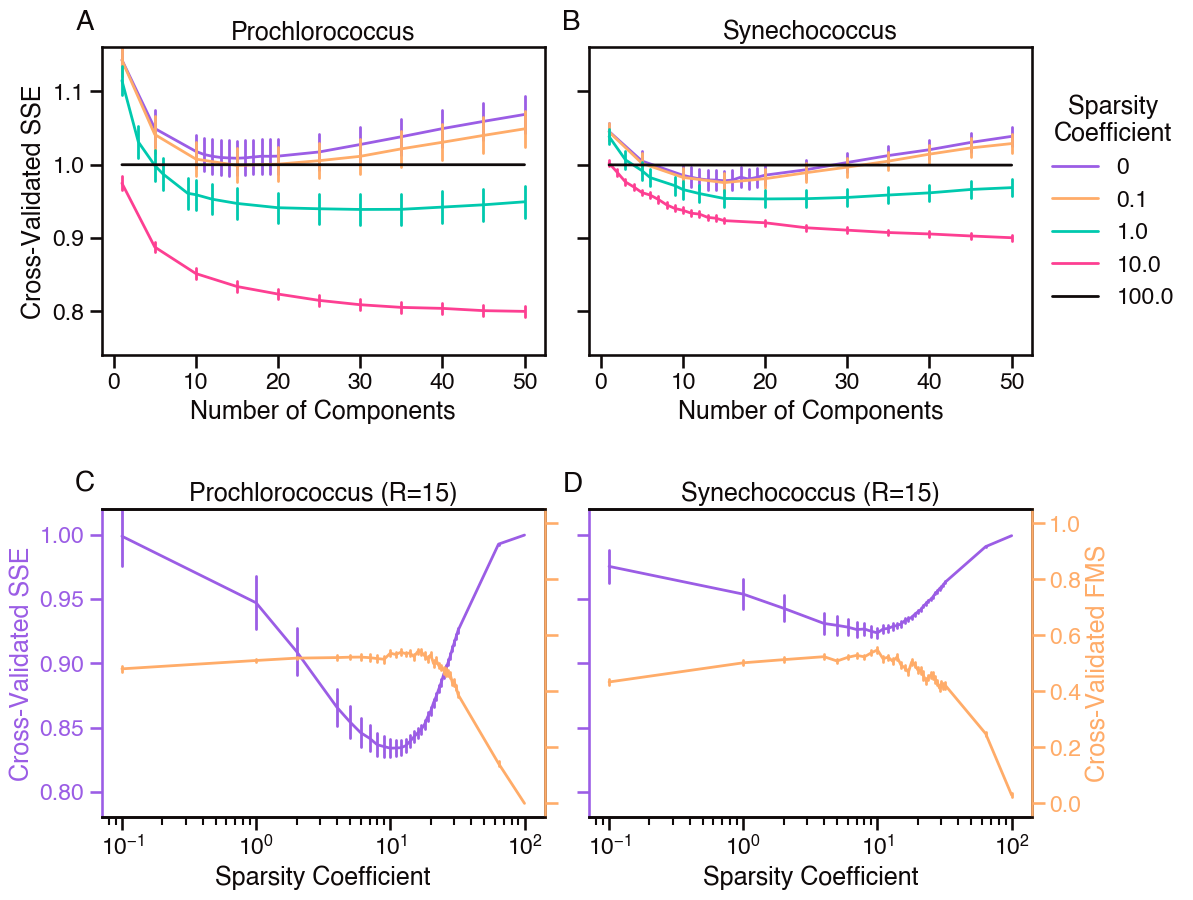

In [11]:
# combined fitting data panels

# define data to plot
plot_bootstraps = np.arange(10)
# r_plot_ranks = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
r_plot_ranks = np.arange(50) + 1
r_plot_lambdas = [0, 0.1, 1., 10., 100.]
l_plot_ranks = {'pro': 15, 'syn': 15}
# l_plot_lambdas = [0.1, 1., 2., 4., 8., 10., 16., 32., 64., 100.]
err_style = 'bars'

# set up subplots
fig, axes = plt.subplots(
    2, 2, figsize=(12, 10), gridspec_kw={'wspace': 0.1, 'hspace': 0.5}
)
annotations = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
annot_kws = dict(
    xy=(-0.06, 1.08), xycoords='axes fraction', va='center', ha='left', 
    weight='bold', fontsize=20, annotation_clip=False
)

# iterate through cyanobacteria
for i, genus in enumerate(['pro', 'syn']):
    # set up genus data
    data_df = results_df[results_df['genus'] == genus]
    data_df = data_df[data_df['bootstrap_id'].isin(plot_bootstraps)]
    data_df = data_df[data_df['modeled_replicate'] != data_df['comparison_replicate']]
    
    # make SSE vs. rank plot
    for j, lamb in enumerate(r_plot_lambdas):
        plot_df = data_df[data_df['rank'].isin(r_plot_ranks)]
        plot_df = plot_df[plot_df['lambda'] == lamb]
        sns.lineplot(
            x='rank', 
            y='relative_sse', 
            color=sns.color_palette()[j], 
            errorbar='se', 
            err_style=err_style, 
            data=plot_df,
            ax=axes[0][i], 
            label=lamb, 
            legend=False
    );
    # set lables and such
    axes[0][i].annotate(annotations[i], **annot_kws)
    if i:
        axes[0][i].set(xlabel='Number of Components', ylabel=None, title='Synechococcus', ylim=[0.74, 1.16])
        axes[0][i].tick_params(labelleft=False)
        axes[0][i].legend(title='\t Sparsity\nCoefficient', alignment='center', 
                          loc='center left', bbox_to_anchor=(1, .5));
    else:
        axes[0][i].set(xlabel='Number of Components', ylabel='Cross-Validated SSE', 
                       title='Prochlorococcus', ylim=[0.74, 1.16])
        
    # make FMS & SSE vs. lambda plot
    # plot_df = data_df[data_df['lambda'].isin(l_plot_lambdas)]
    plot_df = data_df[data_df['lambda'] != 0.0]
    plot_df = plot_df[plot_df['rank'] == l_plot_ranks[genus]]
    # plot SSE
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = False
    color = sns.color_palette()[0]
    sns.lineplot(
        x='lambda', 
        y='relative_sse', 
        color=color, 
        errorbar='se', 
        err_style=err_style,
        data=plot_df, 
        ax=axes[1][i], 
        legend=False
    )
    # set lables and such
    axes[1][i].tick_params(axis='y', colors=color)
    axes[1][i].spines['left'].set_color(color)
    if i:
        axes[1][i].set(ylim=[0.78, 1.02], xlabel='Sparsity Coefficient', xscale='log', ylabel=None)
        axes[1][i].tick_params(labelleft=False)
    else:
        axes[1][i].set(ylim=[0.78, 1.02], xlabel='Sparsity Coefficient', xscale='log', ylabel='Cross-Validated SSE')
        axes[1][i].yaxis.label.set_color(color)

    # plot FMS
    color = sns.color_palette()[1]
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = False
    axis2 = plt.twinx(axes[1][i])
    sns.lineplot(
        x='lambda', 
        y='fms_cv', 
        color=color, 
        errorbar='se', 
        err_style=err_style,
        data=plot_df, 
        ax=axis2, 
        legend=False
    )
    # set lables and such
    axis2.tick_params(axis='y', colors=color)
    axis2.spines['right'].set_color(color)
    axis2.set(title='{} (R={})'.format(
        {'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[genus], l_plot_ranks[genus]))
    axis2.annotate(annotations[2+i], **annot_kws)
    if i:
        axis2.set(ylim=[-.05, 1.05], xlabel='Sparsity Coefficient', xscale='log', ylabel='Cross-Validated FMS')
        axis2.yaxis.label.set_color(color)
    else:
        axis2.set(ylim=[-.05, 1.05], xlabel='Sparsity Coefficient', xscale='log', ylabel=None)
        axis2.tick_params(labelright=False)

    # put defaults back where you found them
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = True
    
fig.savefig(outdir / 'pro-syn-model-fitting.png', bbox_inches='tight')


# Other plots

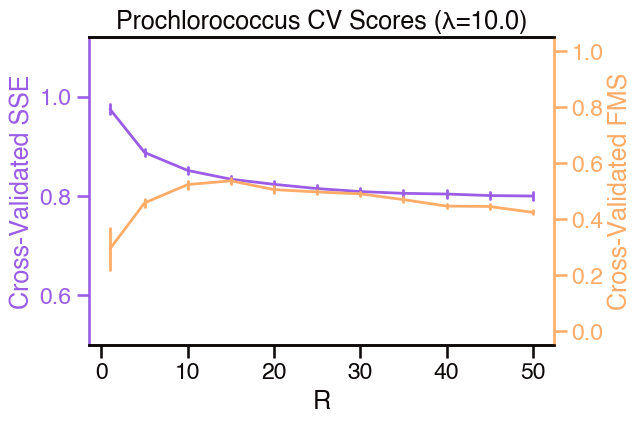

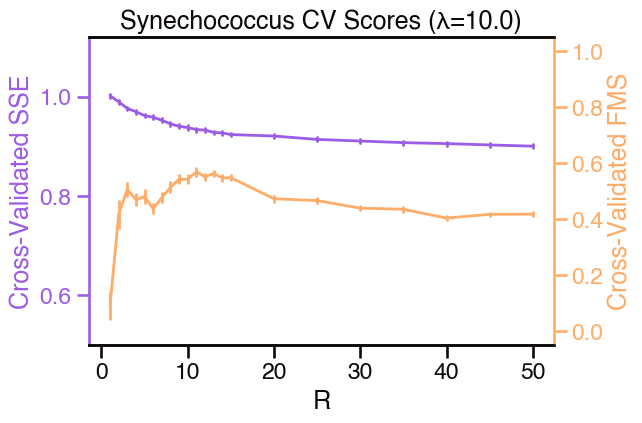

In [12]:
# look at SSE and FMS vs rank

# define data
lamb = 10.0

for cyano in ['pro', 'syn']:
    
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Cross-Validation']
    plot_df = plot_df[plot_df['lambda'] == lamb]

    # plot SSE
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = False
    color = sns.color_palette()[0]
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis, 
        legend=False
    )
    axis.set(ylim=[0.5, 1.12], xlabel='R', ylabel='Cross-Validated SSE')
    axis.yaxis.label.set_color(color)
    axis.tick_params(axis='y', colors=color)
    axis.spines['left'].set_color(color)

    # plot FMS
    color = sns.color_palette()[1]
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = False
    axis2 = plt.twinx(axis)
    sns.lineplot(
        x='rank', 
        y='fms_cv', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis2, 
        legend=False
    )
    axis2.set(ylim=[-.05, 1.05], xlabel='R', ylabel='Cross-Validated FMS')
    axis2.yaxis.label.set_color(color)
    axis2.tick_params(axis='y', colors=color)
    axis2.spines['right'].set_color(color)

    # put defaults back where you found them
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = True

    # fix x axis stuff
    plt.title('{} CV Scores (λ={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano], lamb));
    # plt.savefig(outdir / '{}-cv-scores-v-rank.png'.format(cyano), bbox_inches='tight')


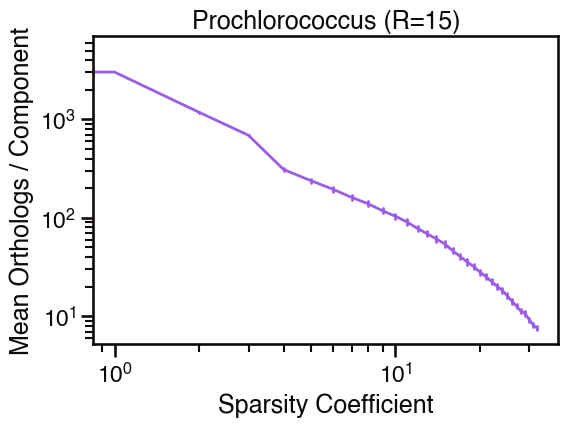

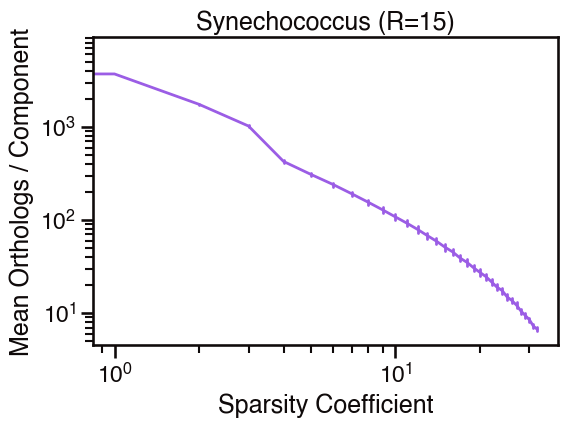

In [13]:
# look at number of nonzero components with sparsity

# define data
ranks = 15
max_lambda = 32.0
for i, cyano in enumerate(['pro', 'syn']):
    # pull data together
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Fitting']
    plot_df = plot_df[plot_df['rank'].eq(ranks)]
    plot_df = plot_df[plot_df['lambda'].le(max_lambda)]
    # plot figure
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='Sparsity Coefficient', 
        y='mean_gene_sparsity', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        ax=axis
    );
    # fix axes and stuff
    axis.set(
        ylabel='Mean Orthologs / Component', xscale='log', yscale='log', 
        title='{} (R={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano], rank)
    )
    # plt.savefig(outdir / '{}-ncomponents-v-rank.png'.format(cyano), bbox_inches='tight')


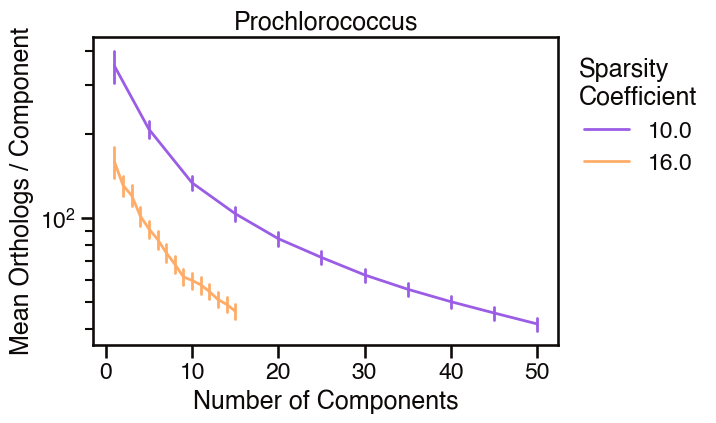

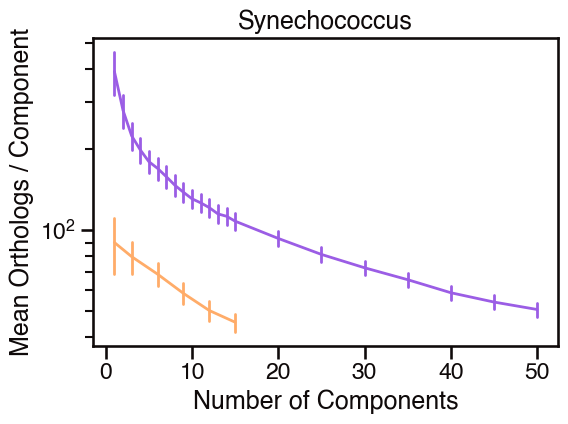

In [14]:
# look at number of nonzero components with rank

# define data
lambs = [10.0, 16.0]
for i, cyano in enumerate(['pro', 'syn']):
    # pull data together
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Fitting']
    plot_df = plot_df[plot_df['lambda'].isin(lambs)]
    # plot figure
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='rank', 
        y='mean_gene_sparsity', 
        hue='Sparsity Coefficient', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        legend=(not i), 
        ax=axis
    );
    # fix axes and stuff
    axis.set(
        xlabel='Number of Components', ylabel='Mean Orthologs / Component', yscale='log', 
        title='{}'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano])
    )
    if not i:
        axis.legend(title='Sparsity\nCoefficient', loc='upper left', bbox_to_anchor=(1, 1))
    # plt.savefig(outdir / '{}-ncomponents-v-rank.png'.format(cyano), bbox_inches='tight')
    